In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import patsy
import statsmodels.api as sm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [2]:
taxi_data = pd.read_parquet("/content/drive/MyDrive/Python Dataset/yellow_tripdata_2020-03.parquet")

In [3]:
fhv_data = pd.read_parquet("/content/drive/MyDrive/Python Dataset/fhvhv_tripdata_2020-03.parquet")

In [4]:
taxi_zone = pd.read_csv("/content/drive/MyDrive/Python Dataset/taxi_zone_lookup.csv")

In [5]:
taxi_zone.dtypes

LocationID       int64
Borough         object
Zone            object
service_zone    object
dtype: object

In [6]:
taxi_data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                      object
dtype: object

#DATA PREPROCESSING

In [7]:
columns_to_remove = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type',
                     'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                     'improvement_surcharge', 'congestion_surcharge',
                     'airport_fee']

taxi_data.drop(columns_to_remove, axis=1, inplace=True)

In [8]:
taxi_data.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
PULocationID                      int64
DOLocationID                      int64
fare_amount                     float64
total_amount                    float64
dtype: object

In [9]:
columns_to_remove_fhv = ['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num','request_datetime',
                         'on_scene_datetime','tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee',
                         'tips', 'driver_pay', 'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
                         'wav_request_flag', 'wav_match_flag']

fhv_data.drop(columns_to_remove_fhv, axis=1, inplace=True)


In [10]:
fhv_data.dtypes

pickup_datetime        datetime64[us]
dropoff_datetime       datetime64[us]
PULocationID                    int64
DOLocationID                    int64
trip_miles                    float64
trip_time                       int64
base_passenger_fare           float64
dtype: object

In [11]:
# Drop null values
taxi_data = taxi_data.dropna()

# Drop duplicate rows
taxi_data = taxi_data.drop_duplicates()

# Reset index after dropping rows
taxi_data = taxi_data.reset_index(drop=True)

In [12]:
# Drop null values
fhv_data = fhv_data.dropna()

# Drop duplicate rows
fhv_data = fhv_data.drop_duplicates()

# Reset index after dropping rows
fhv_data = fhv_data.reset_index(drop=True)

Merging Taxi data and Taxi Zone Data

In [13]:
# Create a dictionary mapping LocationID to Borough and Zone
location_mapping = dict(zip(taxi_zone['LocationID'], taxi_zone[['Borough', 'Zone']].apply(tuple, axis=1)))

# Replace PULocationID with Borough and Zone
taxi_data['PUBorough'], taxi_data['PUZone'] = zip(*taxi_data['PULocationID'].map(location_mapping))

# Replace DOLocationID with Borough and Zone
taxi_data['DOBorough'], taxi_data['DOZone'] = zip(*taxi_data['DOLocationID'].map(location_mapping))

# Drop the original PULocationID and DOLocationID columns
taxi_data.drop(['PULocationID', 'DOLocationID'], axis=1, inplace=True)

# Display the updated DataFrame
print(taxi_data.head())


  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2020-03-01 00:31:13   2020-03-01 01:01:42              1.0           4.70   
1  2020-03-01 00:08:22   2020-03-01 00:08:49              1.0           0.00   
2  2020-03-01 00:52:18   2020-03-01 00:59:16              1.0           1.10   
3  2020-03-01 00:47:53   2020-03-01 00:50:57              2.0           0.87   
4  2020-03-01 00:43:19   2020-03-01 00:58:27              0.0           4.40   

   fare_amount  total_amount  PUBorough                     PUZone  DOBorough  \
0         22.0         27.80  Manhattan   Financial District South   Brooklyn   
1          2.5          3.80     Queens    Queensbridge/Ravenswood     Queens   
2          6.0         11.75  Manhattan  West Chelsea/Hudson Yards  Manhattan   
3          5.0         10.56  Manhattan           Manhattan Valley  Manhattan   
4         16.5         24.35  Manhattan               East Village  Manhattan   

                      DOZone  
0

In [14]:
# Create a dictionary mapping LocationID to Borough and Zone
location_mapping_2 = dict(zip(taxi_zone['LocationID'], taxi_zone[['Borough', 'Zone']].apply(tuple, axis=1)))

# Replace PULocationID with Borough and Zone
fhv_data['PUBorough'], fhv_data['PUZone'] = zip(*fhv_data['PULocationID'].map(location_mapping_2))

# Replace DOLocationID with Borough and Zone
fhv_data['DOBorough'], fhv_data['DOZone'] = zip(*fhv_data['DOLocationID'].map(location_mapping_2))

# Drop the original PULocationID and DOLocationID columns
fhv_data.drop(['PULocationID', 'DOLocationID'], axis=1, inplace=True)

# Display the updated DataFrame
print(fhv_data.head())


      pickup_datetime    dropoff_datetime  trip_miles  trip_time  \
0 2020-03-01 00:03:40 2020-03-01 00:23:39       8.655       1199   
1 2020-03-01 00:28:05 2020-03-01 00:38:57       3.523        652   
2 2020-03-01 00:03:07 2020-03-01 00:15:04       4.070        717   
3 2020-03-01 00:18:42 2020-03-01 00:38:42       4.730       1200   
4 2020-03-01 00:44:24 2020-03-01 00:58:44       4.030        860   

   base_passenger_fare  PUBorough                     PUZone  DOBorough  \
0                24.45      Bronx                Eastchester      Bronx   
1                11.88      Bronx     Mott Haven/Port Morris      Bronx   
2                14.57  Manhattan                   Kips Bay  Manhattan   
3                13.89  Manhattan                    Seaport   Brooklyn   
4                20.20   Brooklyn  Williamsburg (South Side)     Queens   

              DOZone  
0      Melrose South  
1         Highbridge  
2            Seaport  
3  East Williamsburg  
4          Sunnyside  


In [15]:
# Data preprocessing
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])
fhv_data['pickup_datetime'] = pd.to_datetime(fhv_data['pickup_datetime'])
fhv_data['dropoff_datetime'] = pd.to_datetime(fhv_data['dropoff_datetime'])

In [16]:
# Convert negative fare_amount values to positive
taxi_data['fare_amount'] = taxi_data['fare_amount'].abs()

In [17]:
# Convert negative fare_amount values to positive
fhv_data['base_passenger_fare'] = fhv_data['base_passenger_fare'].abs()

#Calculating Trip Duration with the help of Pick Up Time and Drop Off Time

In [18]:
taxi_data['trip_duration'] = (taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']).dt.total_seconds()

In [19]:
taxi_data.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
total_amount                    float64
PUBorough                        object
PUZone                           object
DOBorough                        object
DOZone                           object
trip_duration                   float64
dtype: object

In [20]:
taxi_data.head(3)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,PUBorough,PUZone,DOBorough,DOZone,trip_duration
0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.7,22.0,27.80,Manhattan,Financial District South,Brooklyn,Williamsburg (North Side),1829.0
1,2020-03-01 00:08:22,2020-03-01 00:08:49,1.0,0.0,2.5,3.80,Queens,Queensbridge/Ravenswood,Queens,Queensbridge/Ravenswood,27.0
2,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.1,6.0,11.75,Manhattan,West Chelsea/Hudson Yards,Manhattan,Flatiron,418.0


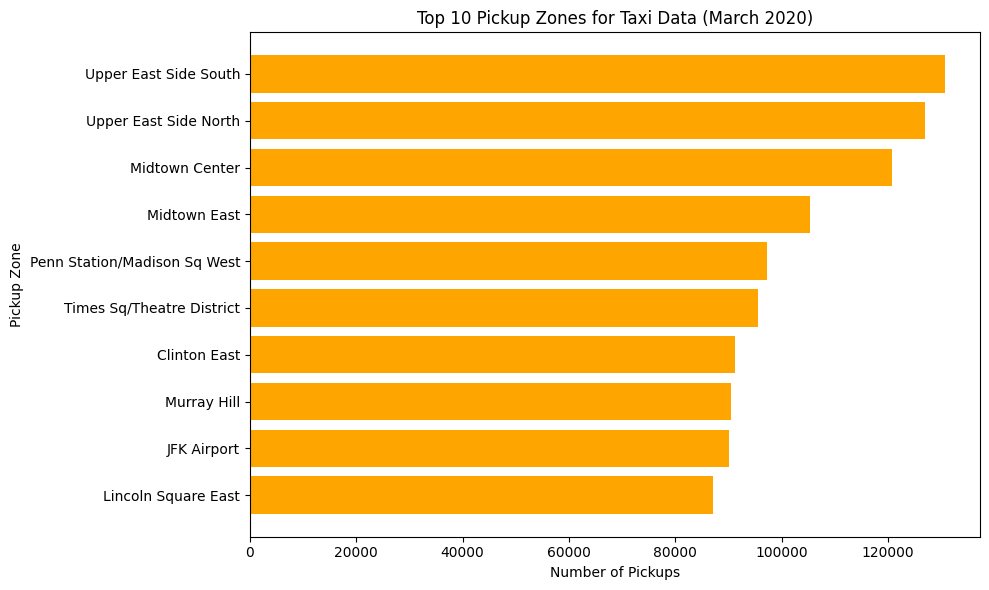

In [21]:
# Assuming you have a DataFrame named fhv_data with columns 'PUZone' and 'pickup_count'
top_10_taxi_pickup_zones = taxi_data.groupby('PUZone').size().reset_index(name='pickup_count').nlargest(10, 'pickup_count')


# Plot top 10 pickup zones for taxi data
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_taxi_pickup_zones)), top_10_taxi_pickup_zones['pickup_count'], color='orange')
plt.yticks(range(len(top_10_taxi_pickup_zones)), top_10_taxi_pickup_zones['PUZone'])
plt.xlabel('Number of Pickups')
plt.ylabel('Pickup Zone')
plt.title('Top 10 Pickup Zones for Taxi Data (March 2020)')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.tight_layout()
plt.show()

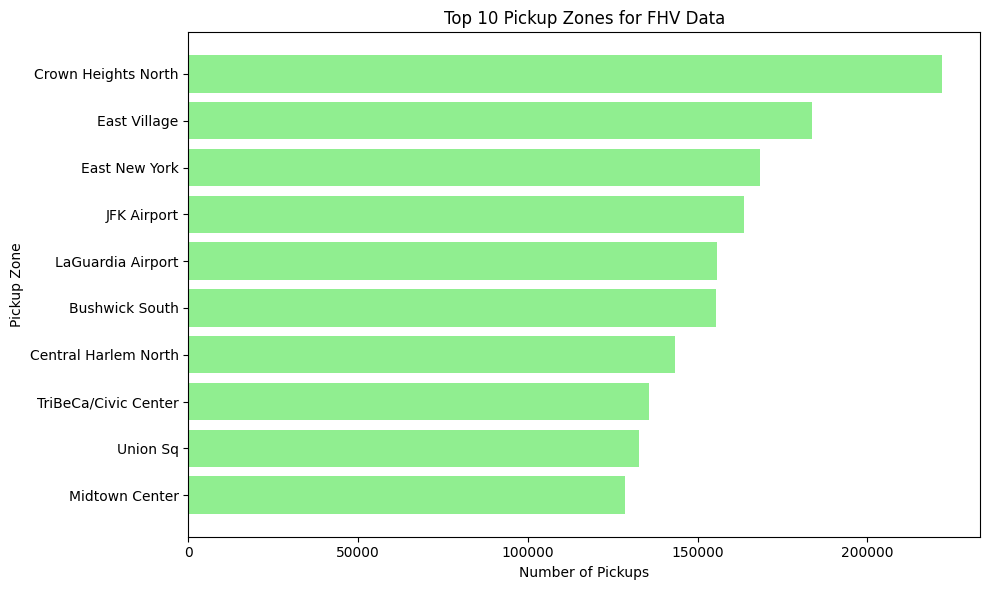

In [22]:
# Assuming you have a DataFrame named fhv_data with columns 'PUZone' and 'pickup_count'
top_10_fhv_pickup_zones = fhv_data.groupby('PUZone').size().reset_index(name='pickup_count').nlargest(10, 'pickup_count')

# Plot top 10 pickup zones for FHV data
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_fhv_pickup_zones)), top_10_fhv_pickup_zones['pickup_count'], color='lightgreen')
plt.yticks(range(len(top_10_fhv_pickup_zones)), top_10_fhv_pickup_zones['PUZone'])
plt.xlabel('Number of Pickups')
plt.ylabel('Pickup Zone')
plt.title('Top 10 Pickup Zones for FHV Data')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.tight_layout()
plt.show()


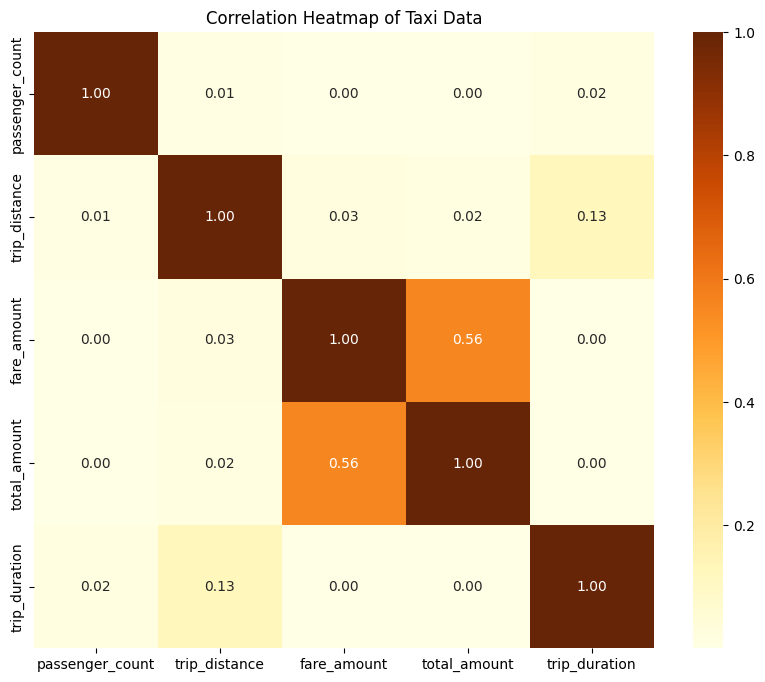

In [23]:
# Exclude non-numeric columns from the correlation calculation
numeric_columns = taxi_data.select_dtypes(include=[np.number])
taxi_correlation_matrix = numeric_columns.corr()

# Plot heatmap for taxi_data
plt.figure(figsize=(10, 8))
sns.heatmap(taxi_correlation_matrix, annot=True, cmap='YlOrBr', fmt=".2f")
plt.title('Correlation Heatmap of Taxi Data')
plt.show()


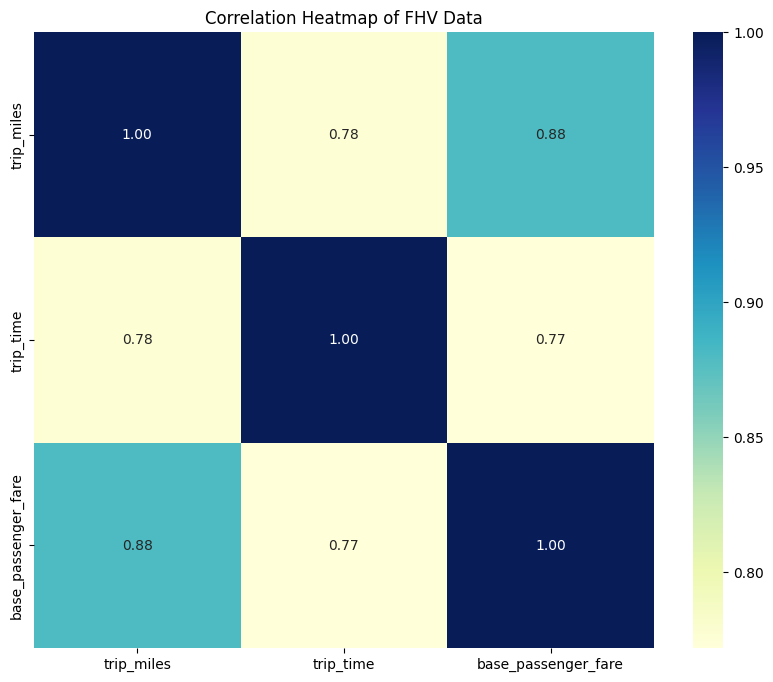

In [24]:
# Exclude non-numeric columns from the correlation calculation
numeric_columns_fhv = fhv_data.select_dtypes(include=[np.number])
fhv_correlation_matrix = numeric_columns_fhv.corr()

# Plot heatmap for fhv_data
plt.figure(figsize=(10, 8))
sns.heatmap(fhv_correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Heatmap of FHV Data')
plt.show()


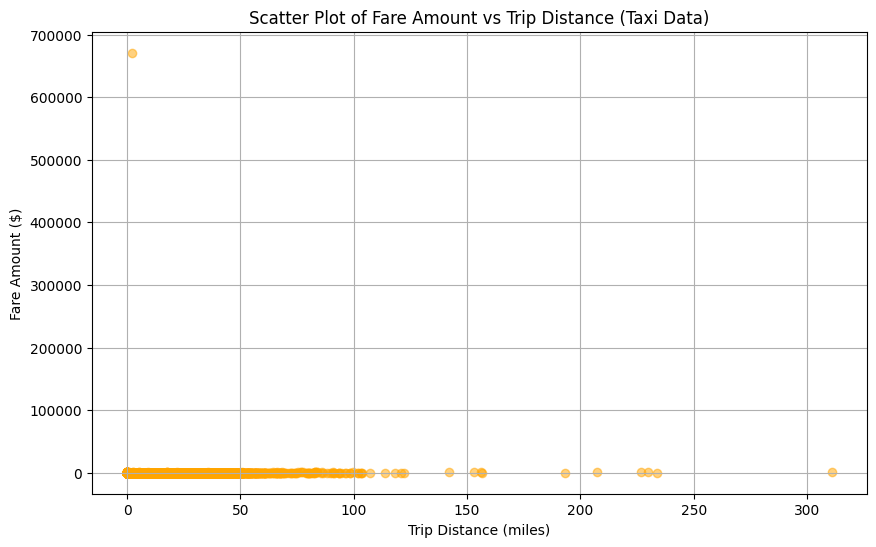

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(taxi_data['trip_distance'], taxi_data['fare_amount'], alpha=0.5, color='orange')
plt.title('Scatter Plot of Fare Amount vs Trip Distance (Taxi Data)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()


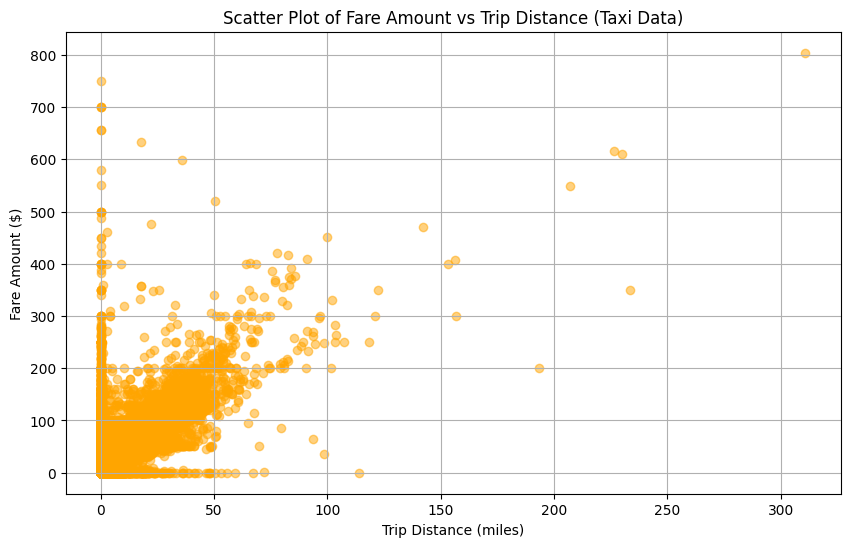

In [26]:
plt.figure(figsize=(10, 6))

# Filter out data points where fare_amount is greater than 1000
filtered_taxi_data = taxi_data[taxi_data['fare_amount'] <= 1000]

plt.scatter(filtered_taxi_data['trip_distance'], filtered_taxi_data['fare_amount'], alpha=0.5, color='orange')
plt.title('Scatter Plot of Fare Amount vs Trip Distance (Taxi Data)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()


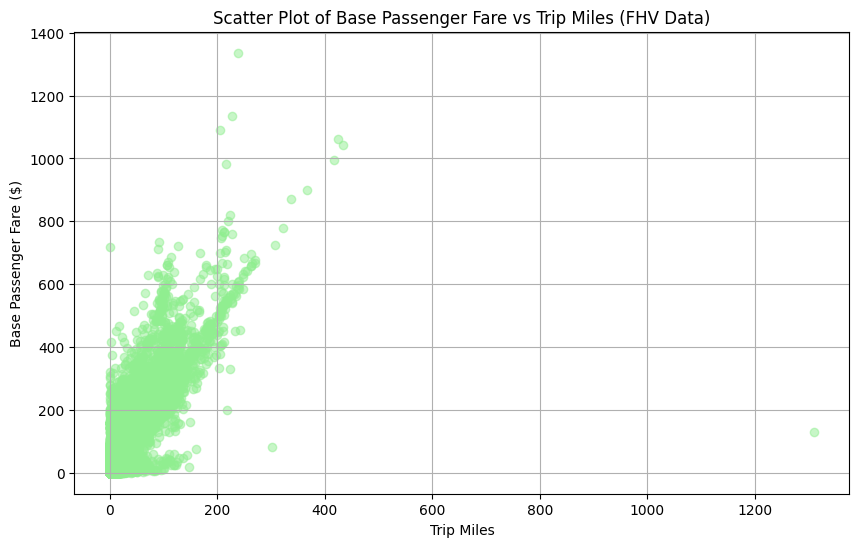

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(fhv_data['trip_miles'], fhv_data['base_passenger_fare'], alpha=0.5, color='lightgreen')
plt.title('Scatter Plot of Base Passenger Fare vs Trip Miles (FHV Data)')
plt.xlabel('Trip Miles')
plt.ylabel('Base Passenger Fare ($)')
plt.grid(True)
plt.show()


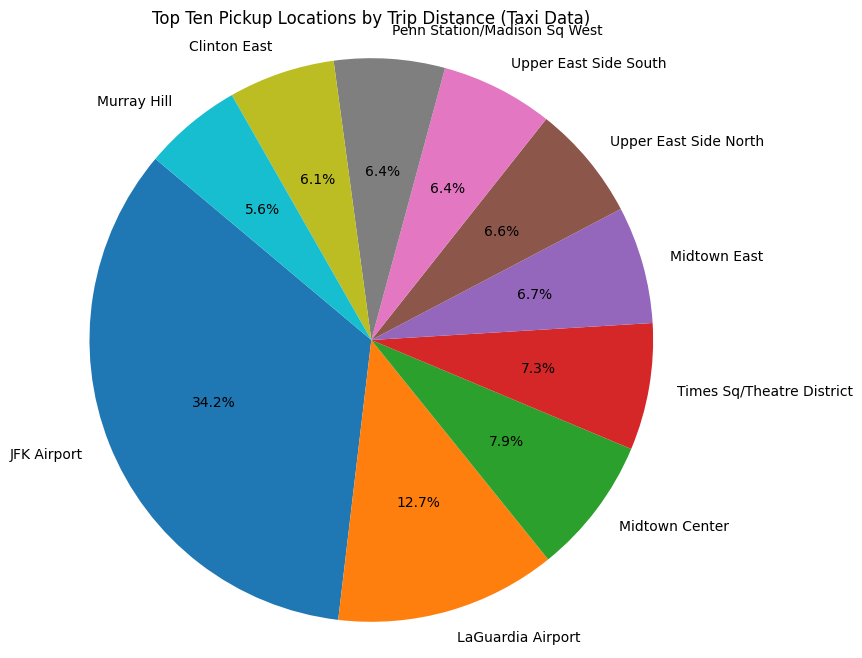

In [28]:
# Calculate the top ten locations with highest trip distance
top_10_taxi_locations = taxi_data.groupby('PUZone')['trip_distance'].sum().nlargest(10)

# Plot pie chart for trip distance in taxi data
plt.figure(figsize=(8, 8))
plt.pie(top_10_taxi_locations, labels=top_10_taxi_locations.index, autopct='%1.1f%%', startangle=140)
plt.title('Top Ten Pickup Locations by Trip Distance (Taxi Data)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

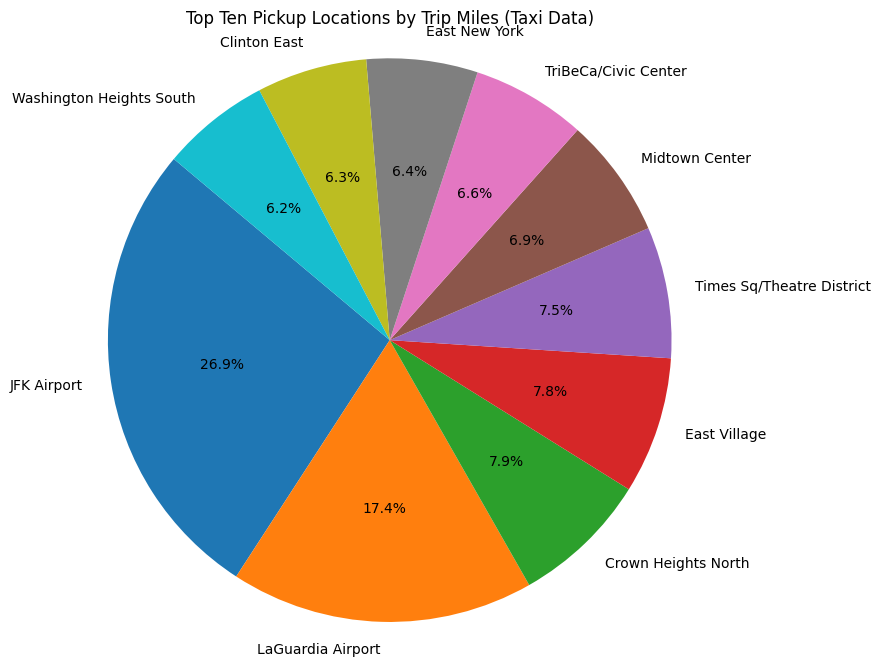

In [29]:
# Calculate the top ten locations with highest trip miles
top_10_taxi_miles = fhv_data.groupby('PUZone')['trip_miles'].sum().nlargest(10)

# Plot pie chart for trip miles in taxi data
plt.figure(figsize=(8, 8))
plt.pie(top_10_taxi_miles, labels=top_10_taxi_miles.index, autopct='%1.1f%%', startangle=140)
plt.title('Top Ten Pickup Locations by Trip Miles (Taxi Data)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [30]:
fhv_data.dtypes

pickup_datetime        datetime64[us]
dropoff_datetime       datetime64[us]
trip_miles                    float64
trip_time                       int64
base_passenger_fare           float64
PUBorough                      object
PUZone                         object
DOBorough                      object
DOZone                         object
dtype: object

In [31]:
taxi_data.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
total_amount                    float64
PUBorough                        object
PUZone                           object
DOBorough                        object
DOZone                           object
trip_duration                   float64
dtype: object

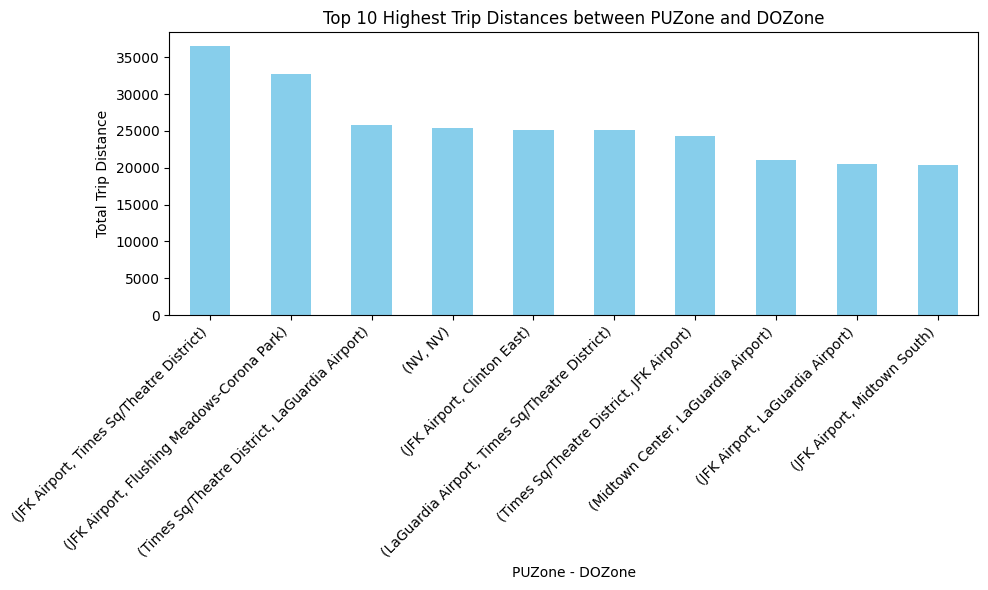

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named taxi_data
top_10_trip_distances = taxi_data.groupby(['PUZone', 'DOZone'])['trip_distance'].sum().nlargest(10)

# Plot bar graph for top ten highest trip distances
plt.figure(figsize=(10, 6))
top_10_trip_distances.plot(kind='bar', color='skyblue')
plt.title('Top 10 Highest Trip Distances between PUZone and DOZone')
plt.xlabel('PUZone - DOZone')
plt.ylabel('Total Trip Distance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


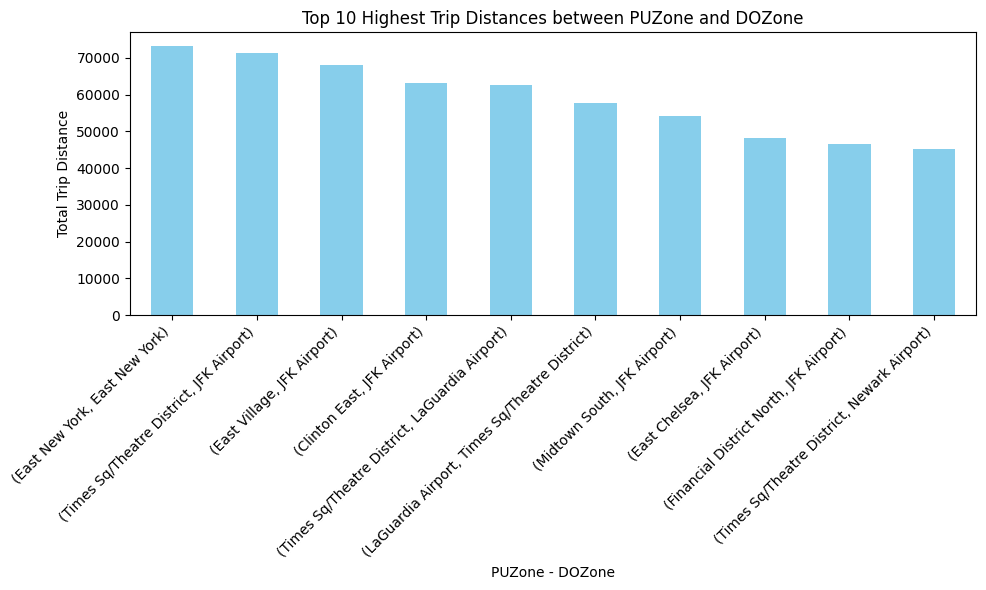

In [33]:
# Assuming you have a DataFrame named taxi_data
top_10_trip_distances = fhv_data.groupby(['PUZone', 'DOZone'])['trip_miles'].sum().nlargest(10)

# Plot bar graph for top ten highest trip distances
plt.figure(figsize=(10, 6))
top_10_trip_distances.plot(kind='bar', color='skyblue')
plt.title('Top 10 Highest Trip Distances between PUZone and DOZone')
plt.xlabel('PUZone - DOZone')
plt.ylabel('Total Trip Distance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


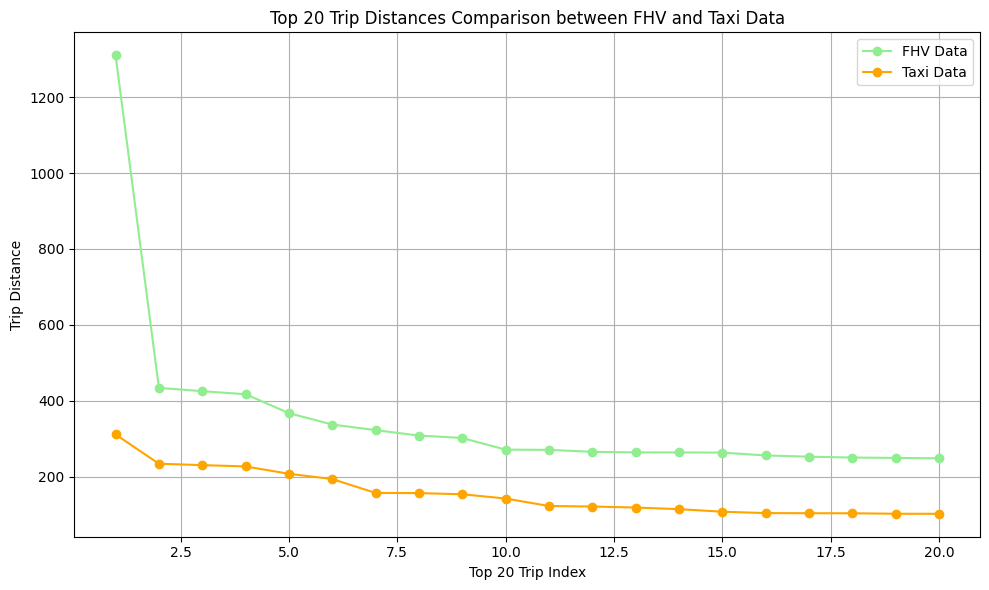

In [34]:
# Get the top 20 trip distances for FHV data
top_20_fhv_trip_distances = fhv_data['trip_miles'].nlargest(20)

# Get the top 20 trip distances for taxi data
top_20_taxi_trip_distances = taxi_data['trip_distance'].nlargest(20)

# Plot line graph for top 20 trip distances for FHV data
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), top_20_fhv_trip_distances, marker='o', label='FHV Data', color='lightgreen')

# Plot line graph for top 20 trip distances for taxi data
plt.plot(range(1, 21), top_20_taxi_trip_distances, marker='o', label='Taxi Data', color='orange')

# Set labels and title
plt.xlabel('Top 20 Trip Index')
plt.ylabel('Trip Distance')
plt.title('Top 20 Trip Distances Comparison between FHV and Taxi Data')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

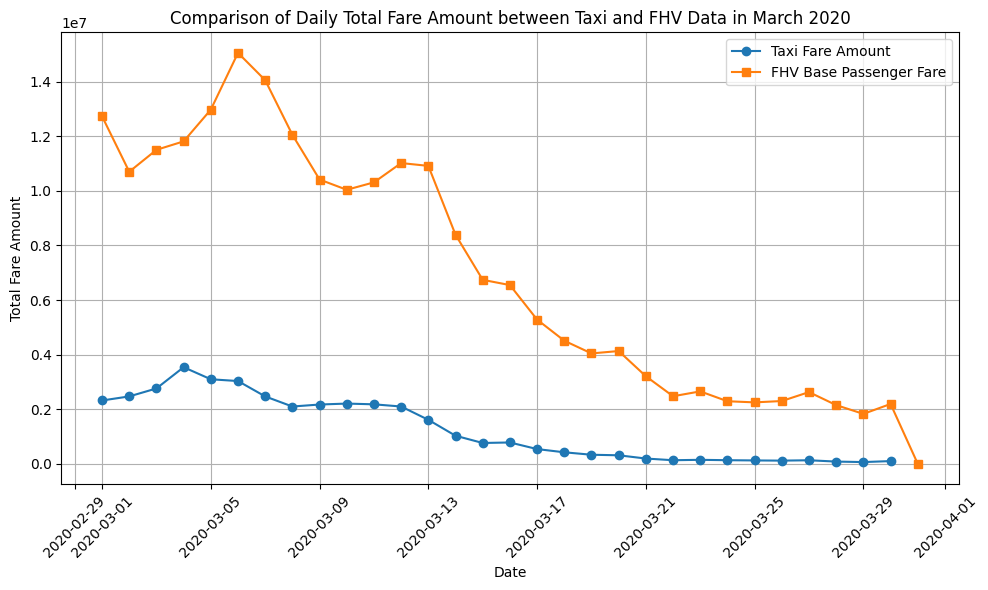

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter taxi_data for March 2020
taxi_data_march = taxi_data[(taxi_data['tpep_pickup_datetime'] >= '2020-03-01') & (taxi_data['tpep_pickup_datetime'] <= '2020-03-31')]

# Filter fhv_data for March 2020
fhv_data_march = fhv_data[(fhv_data['pickup_datetime'] >= '2020-03-01') & (fhv_data['pickup_datetime'] <= '2020-03-31')]

# Calculate the daily total fare amount for taxi_data in March 2020
daily_taxi_fare = taxi_data_march.groupby(taxi_data_march['tpep_pickup_datetime'].dt.date)['fare_amount'].sum()

# Calculate the daily total base passenger fare for fhv_data in March 2020
daily_fhv_fare = fhv_data_march.groupby(fhv_data_march['pickup_datetime'].dt.date)['base_passenger_fare'].sum()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(daily_taxi_fare.index, daily_taxi_fare.values, marker='o', label='Taxi Fare Amount')
plt.plot(daily_fhv_fare.index, daily_fhv_fare.values, marker='s', label='FHV Base Passenger Fare')
plt.xlabel('Date')
plt.ylabel('Total Fare Amount')
plt.title('Comparison of Daily Total Fare Amount between Taxi and FHV Data in March 2020')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


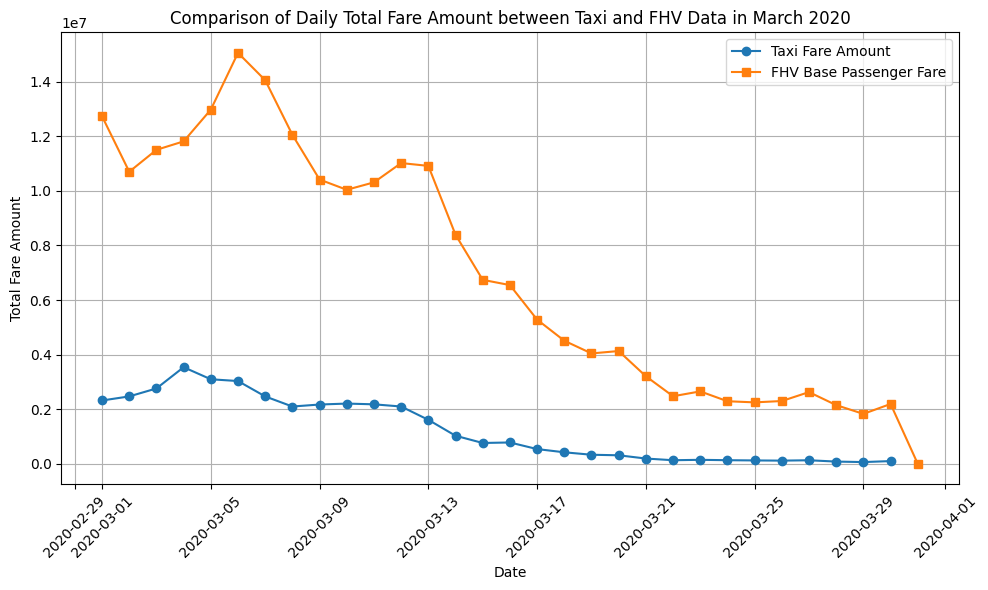

In [36]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(daily_taxi_fare.index, daily_taxi_fare.values, marker='o', label='Taxi Fare Amount')
plt.plot(daily_fhv_fare.index, daily_fhv_fare.values, marker='s', label='FHV Base Passenger Fare')
plt.xlabel('Date')
plt.ylabel('Total Fare Amount')
plt.title('Comparison of Daily Total Fare Amount between Taxi and FHV Data in March 2020')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Sklearn

In [37]:
design_matrix = patsy.dmatrix('trip_distance + fare_amount', taxi_data)
print(design_matrix)

[[ 1.    4.7  22.  ]
 [ 1.    0.    2.5 ]
 [ 1.    1.1   6.  ]
 ...
 [ 1.    1.33  7.  ]
 [ 1.    0.87  5.  ]
 [ 1.    2.8  10.5 ]]


In [38]:
taxi_data['total_amount']

0          27.80
1           3.80
2          11.75
3          10.56
4          24.35
           ...  
2969874     7.80
2969875    17.16
2969876    13.00
2969877    11.44
2969878    15.30
Name: total_amount, Length: 2969879, dtype: float64

In [39]:
model = sm.OLS(taxi_data['total_amount'], design_matrix)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                 6.694e+05
Date:                Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                        14:04:39   Log-Likelihood:            -2.3113e+07
No. Observations:             2969879   AIC:                         4.623e+07
Df Residuals:                 2969876   BIC:                         4.623e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7280      0.427     11.065      0.0

In [40]:
design_matrix

DesignMatrix with shape (2969879, 3)
  Intercept  trip_distance  fare_amount
          1           4.70         22.0
          1           0.00          2.5
          1           1.10          6.0
          1           0.87          5.0
          1           4.40         16.5
          1           3.50         15.0
          1          14.10         40.5
          1           1.00          7.0
          1           1.10          7.5
          1           1.30          6.5
          1           1.40          8.0
          1           1.80          9.5
          1           1.20          9.5
          1           6.20         24.5
          1           1.20          7.5
          1           7.20         24.5
          1           3.50         14.5
          1           1.00          6.5
          1           2.50         10.0
          1           1.00          6.5
          1           0.93          6.0
          1           0.84          5.0
          1           5.11         17.0
   

In [41]:
X_train, X_test, y_train, y_test = train_test_split(design_matrix, taxi_data['total_amount'], test_size=0.3)

In [42]:
X_train

array([[ 1.  ,  0.8 ,  5.  ],
       [ 1.  , 16.2 , 52.  ],
       [ 1.  ,  1.9 , 10.5 ],
       ...,
       [ 1.  ,  3.12, 12.  ],
       [ 1.  ,  2.8 , 12.  ],
       [ 1.  ,  3.18, 15.5 ]])

In [43]:
len(X_train)

2078915

In [44]:
y_train

256532     10.30
663138     66.36
685008     13.80
2920505    11.30
2612733    12.43
           ...  
1194551    13.55
423427     14.76
336056     15.80
860836     17.60
1707657    20.80
Name: total_amount, Length: 2078915, dtype: float64

In [45]:
len(y_train)

2078915

In [46]:
model = LinearRegression()

In [47]:
model.fit(X_train, y_train)

LinearRegression()

In [48]:
y_predict=model.predict(X_test)

In [49]:
print(r2_score(y_test,y_predict))

0.9994255831781337


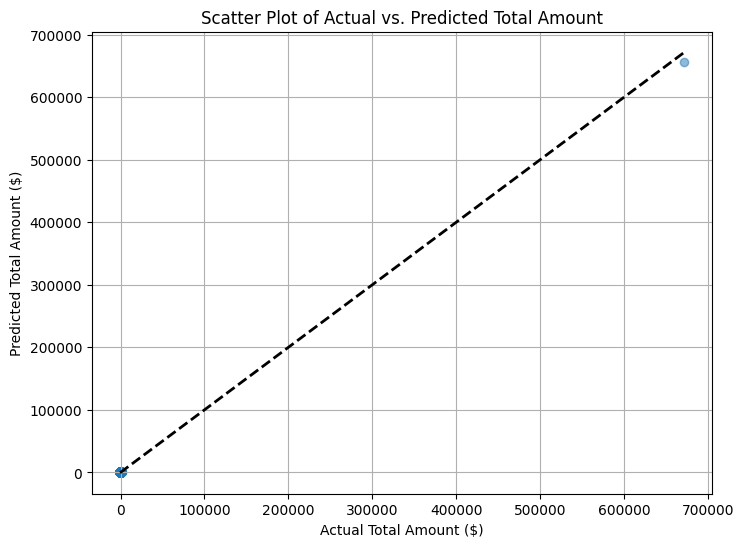

In [50]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Total Amount ($)')
plt.ylabel('Predicted Total Amount ($)')
plt.title('Scatter Plot of Actual vs. Predicted Total Amount')
plt.grid(True)
plt.show()

In [57]:
# Calculate residuals
residuals = y_test - y_predict

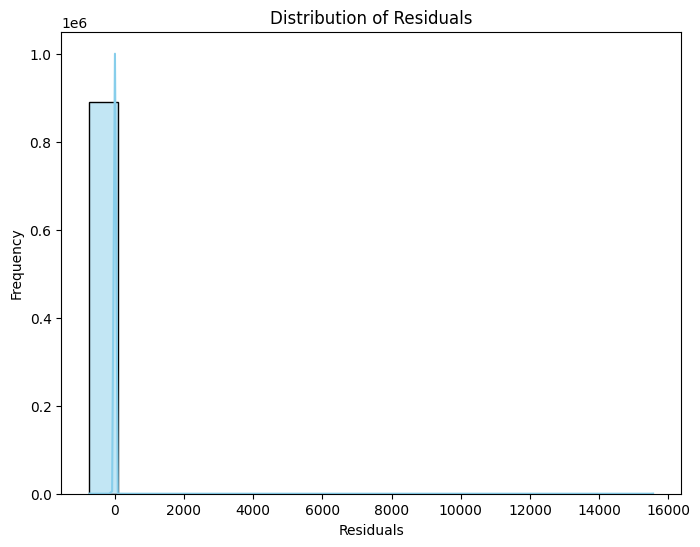

In [58]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='skyblue', bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()